# 1. Imports 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from IPython.display import display
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.preprocessing import OneHotEncoder
from pathlib import Path

In [2]:
import warnings
warnings.filterwarnings('ignore')

# 2. Load data 

In [3]:
train_df = pd.read_csv('../data/train.csv').drop(columns='id')
#We keep the test_df indexes for submission before droping them 
test_df = pd.read_csv('../data/test.csv')
test_idx = test_df ['id']
test_df = test_df.drop(columns='id')
print(f'Train dataframe shape: {train_df.shape}')
print(f'Test dataframe shape: {test_df.shape}')
TARGET = 'Attrition'
FEATURES = [col for col in train_df.columns if col not in ['row_id',TARGET]]

#People has demonstrated that incorporating original data, improves scores in the public leaderboard
original_df = pd.read_csv('../data/WA_Fn-UseC_-HR-Employee-Attrition.csv').drop(columns='EmployeeNumber')

Train dataframe shape: (1677, 34)
Test dataframe shape: (1119, 33)


In [4]:
train_df.head(5)

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EnvironmentSatisfaction,Gender,...,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,36,Travel_Frequently,599,Research & Development,24,3,Medical,1,4,Male,...,80,1,10,2,3,10,0,7,8,0
1,35,Travel_Rarely,921,Sales,8,3,Other,1,1,Male,...,80,1,4,3,3,4,2,0,3,0
2,32,Travel_Rarely,718,Sales,26,3,Marketing,1,3,Male,...,80,2,4,3,3,3,2,1,2,0
3,38,Travel_Rarely,1488,Research & Development,2,3,Medical,1,3,Female,...,80,0,15,1,1,6,0,0,2,0
4,50,Travel_Rarely,1017,Research & Development,5,4,Medical,1,2,Female,...,80,0,31,0,3,31,14,4,10,1


There are 33 unique features to work with and just few training examples (1677) compared to the number of variables. This can lead to overfitting. Hence, adding the original dataset can be a good approach to generalize to unseen data to limit the overfitting. 

It would be interesting to analyze the differences between both datasets as was done in the previous competition by 

# 3. EDA - train data

## 3.1. Overview of the data

In [5]:
#Let's search for NaNs
train_df.isna().sum().sum()

0

In [6]:

#Basic statistics for each variables 
#Background color determined according to the data in each column
#Bar fulfilling the cells in the dataframe according to the value in max and mean columns
train_df.iloc[:,:-1].describe().T.sort_values(by='std', ascending=False)\
    .style.background_gradient(cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
MonthlyRate,1677.000000,14770.048301,7112.203888,636.000000,8509.000000,15332.000000,20990.000000,26999.000000
MonthlyIncome,1677.000000,6196.049493,4520.050754,1010.000000,2875.000000,4834.000000,7403.000000,19973.000000
DailyRate,1677.000000,892.749553,374.496259,107.000000,589.000000,890.000000,1223.000000,3921.000000
HourlyRate,1677.000000,67.798450,19.435928,30.000000,51.000000,69.000000,84.000000,100.000000
Age,1677.000000,36.036971,8.507112,18.000000,30.000000,35.000000,41.000000,60.000000
DistanceFromHome,1677.000000,8.683959,7.826143,1.000000,2.000000,7.000000,12.000000,29.000000
TotalWorkingYears,1677.000000,10.709600,7.255135,0.000000,6.000000,9.000000,14.000000,41.000000
YearsAtCompany,1677.000000,6.806798,5.883282,0.000000,3.000000,5.000000,9.000000,41.000000
YearsInCurrentRole,1677.000000,4.144305,3.583398,0.000000,2.000000,3.000000,7.000000,18.000000
YearsWithCurrManager,1677.000000,4.186643,3.576189,0.000000,2.000000,3.000000,7.000000,17.000000


In [7]:
train_df['Age'].dtypes

dtype('int64')

In [8]:
# Number of unique variables per feature and variable type
for col in train_df[FEATURES].columns: 
    print(f'{col}: {train_df[col].nunique() } type: {train_df[col].dtypes}')

Age: 43 type: int64
BusinessTravel: 3 type: object
DailyRate: 625 type: int64
Department: 3 type: object
DistanceFromHome: 29 type: int64
Education: 6 type: int64
EducationField: 6 type: object
EmployeeCount: 1 type: int64
EnvironmentSatisfaction: 4 type: int64
Gender: 2 type: object
HourlyRate: 71 type: int64
JobInvolvement: 4 type: int64
JobLevel: 6 type: int64
JobRole: 9 type: object
JobSatisfaction: 4 type: int64
MaritalStatus: 3 type: object
MonthlyIncome: 895 type: int64
MonthlyRate: 903 type: int64
NumCompaniesWorked: 10 type: int64
Over18: 1 type: object
OverTime: 2 type: object
PercentSalaryHike: 15 type: int64
PerformanceRating: 2 type: int64
RelationshipSatisfaction: 4 type: int64
StandardHours: 1 type: int64
StockOptionLevel: 4 type: int64
TotalWorkingYears: 41 type: int64
TrainingTimesLastYear: 7 type: int64
WorkLifeBalance: 4 type: int64
YearsAtCompany: 34 type: int64
YearsInCurrentRole: 19 type: int64
YearsSinceLastPromotion: 16 type: int64
YearsWithCurrManager: 18 type:

## 3.2. Categorical and continuous data

Total number of features: 33
Number of categorical (<25 Unique Values) features: 25
Number of continuos features: 8


([<matplotlib.patches.Wedge at 0x233dea43e80>,
 [Text(-0.7961074246862808, 0.7590869306998889, 'Categorical (<25 unique values)'),
  Text(0.7961074246862808, -0.759086930699889, 'Continuous')],
 [Text(-0.43424041346524406, 0.41404741674539386, '75.8%'),
  Text(0.43424041346524406, -0.4140474167453939, '24.2%')])

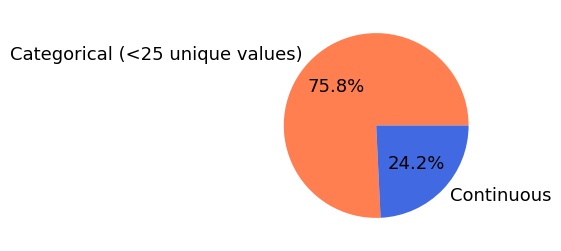

In [9]:
df = pd.concat([train_df[FEATURES], test_df[FEATURES]], axis=0)
categorical_features = [col for col in FEATURES if df[col].nunique()<25]
continuous_features = [col for col in FEATURES if df[col].nunique()>=25]
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical (<25 Unique Values) features: {len(categorical_features)}')
print(f'\033[93mNumber of continuos features: {len(continuous_features)}')

fig = plt.figure(figsize=(5,3))
plt.pie(
    [len(categorical_features), len(continuous_features)],
    labels=['Categorical (<25 unique values)','Continuous'],
    colors=['coral','royalblue'],
    textprops={'fontsize':13},
    autopct='%1.1f%%') #Autopct shows % of the pie in each label

## 3.3. Feature distribution of Continuous features
Show the distribution of the features for each of the 8 continuous features.

- A kernel density estimate (KDE) plot is a method for visualizing the distribution of observations in a dataset, analogous to a histogram. 
- KDE represents the data using a continuous probability density curve in one or more dimensions. 
- Relative to histogram, KDE can produce a plot that is less messy and more interpretable, specially when drawing **multiple** distributions in the same plot. 

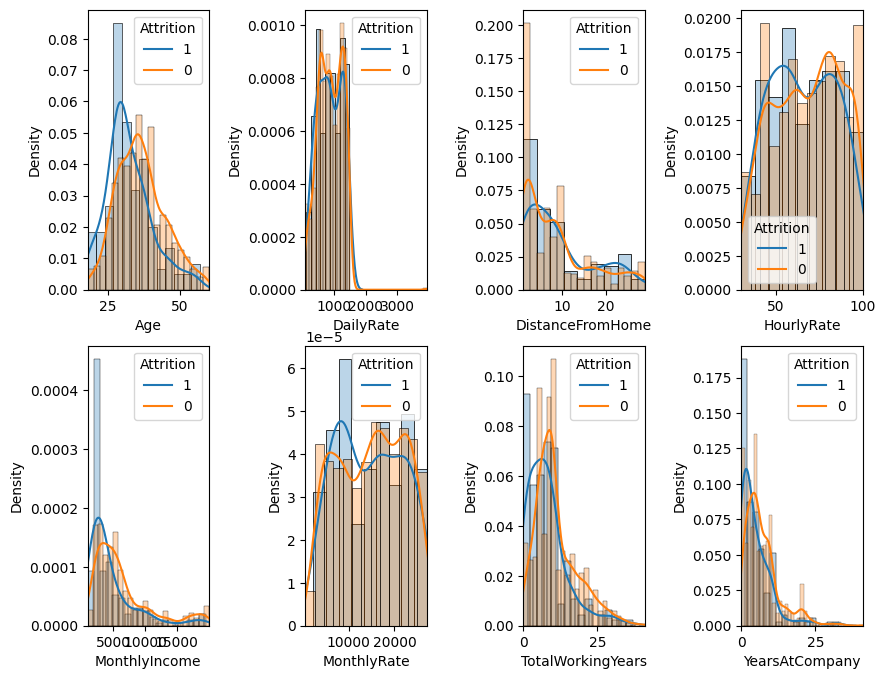

In [10]:
# There are 8 continuous features --> KDE --> (2,4) matrix for subplots
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10,8))
plt.subplots_adjust(wspace=0.8)
for r in range(nrows):
    for c in range(ncols):
        col = np.array(continuous_features).reshape(2,4)[r,c]
        col = continuous_features[r*ncols+c]
        sns.kdeplot(train_df[train_df['Attrition']==1][col], label=1, ax = axes[r,c])
        sns.histplot(train_df[train_df['Attrition']==1][col], alpha = 0.3, stat='density', ax = axes[r,c])
        sns.kdeplot(train_df[train_df['Attrition']==0][col], label = 0, ax = axes[r,c])
        sns.histplot(train_df[train_df['Attrition']==0][col], alpha = 0.3, stat='density', ax = axes[r,c])
        min_f = train_df[col].min()
        max_f = train_df[col].max()
        axes[r,c].legend(title='Attrition')
        axes[r,c].set_xlim([min_f, max_f])

From the continuous plots we can observe the following: 
- Younger people tend to have more attrition 
- People near to the workplace tend to have less attrition
- People who earn less in MonthlyIncome tend to have more attrition
- People who have been less years into the company tend to have more attrition

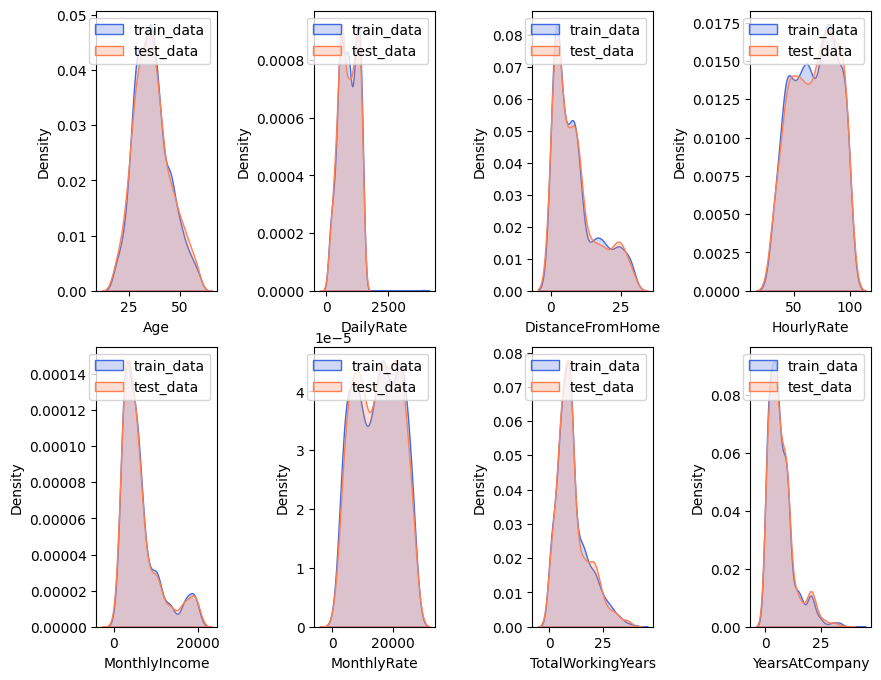

In [11]:
# Comparing trianing and test data
# There are 8 continuous features --> KDE --> (2,4) matrix for subplots
nrows = 2
ncols = 4
fig, axes = plt.subplots(nrows, ncols, figsize=(10,8))
plt.subplots_adjust(wspace=0.8)
for r in range(nrows):
    for c in range(ncols):
        col = np.array(continuous_features).reshape(2,4)[r,c]
        col = continuous_features[r*ncols+c]
        sns.kdeplot(train_df[col],fill=True, color='royalblue',label='train_data',ax = axes[r,c])
        sns.kdeplot(test_df[col],fill=True, color='coral', label='test_data',ax = axes[r,c])
        axes[r,c].legend()



## 4. Data Cleaning & Preprocessing

## 4.1. Data imputing 

- There's one "Education" == 15 
- There's one "Environment satisfaction" == 0 
- There's one "JobInvolvement" == 0 
- There's one "JobLevel" == 7 
- There's one "StockOptionLevel" == 4 

These rows with unique values that are outliers/categories with just one rows will be imputed as the class with more presence in the dataset 

In [12]:
#Imputing outliers
train_df.loc[train_df['Education']==15, 'Education'] = 3
train_df.loc[train_df['JobInvolvement']==1, 'JobInvolvement'] = 3
train_df.loc[train_df['JobLevel']==7, 'JobLevel'] = 1

test_df.loc[test_df['EnvironmentSatisfaction']== 0, 'EnvironmentSatisfaction'] = 4
test_df.loc[test_df['JobInvolvement']== 0, 'JobInvolvement'] = 3
test_df.loc[test_df['StockOptionLevel']== 4, 'StockOptionLevel'] = 0


Regarding the DailyRate column, there are few values that do not make sense --> 
Train_df: DailyRate == 3921
Test_df: DailyRate == 6

In [13]:
train_df.loc[train_df['DailyRate']==3921, 'DailyRate'] = int(train_df['DailyRate'].median())
test_df.loc[test_df['DailyRate']==6, 'DailyRate'] = int(test_df['DailyRate'].median())

Columns: 
- 'EmployeeCount' 
- 'Over18'
- 'StandardHours'
Can be deleted as there is a unique label for all the samples. 

In [14]:
DROP_FEATURES = ['EmployeeCount', 'Over18', 'StandardHours']
FEATURES.remove(DROP_FEATURES[0])
FEATURES.remove(DROP_FEATURES[1])
FEATURES.remove(DROP_FEATURES[2])
categorical_features = [col for col in FEATURES if df[col].nunique()<25]
continuous_features = [col for col in FEATURES if df[col].nunique()>=25]
print(f'Total number of features: {len(FEATURES)}')
print(f'\033[92mNumber of categorical (<25 Unique Values) features: {len(categorical_features)}')
print(f'\033[93mNumber of continuos features: {len(continuous_features)}')

Total number of features: 30
Number of categorical (<25 Unique Values) features: 22
Number of continuos features: 8


In [15]:
train_df = train_df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])
test_df = test_df.drop(columns=['EmployeeCount', 'Over18', 'StandardHours'])

## 4.2  Encode features
There are different types of features. 
Categorical features can be ordinal or nominal and formatted as string or int. 
The idea is to encode string features. The ordinal ones can be encoded through a mapping dictionary while nominal ones should be encoded using One-Hot-Encoding 
- The categorical ordinal features can be encoded through LabelEncoder. 
    - BusinessTravel (str)
    - Education (int)
    - EnvironmentSatisfaction (int)
    - JobInvolvement (int)
    - JobLevel (int)
    - JobSatisfaction (int)
    - NumCompaniesWorked (int)
    - PercentSalaryHike (int)
    - PerformanceRating (int)
    - RelationshipSatisfaction (int)
    - StockOptionLevel (int)
    - TrainingTimesLastYear (int)
    - WorkLifeBalance (int)
    - YearsInCurrentRole (int)
    - YearsSinceLastPromotion (int)
    - YearsWithCurrManager (int)
- The categorical nominal features can be encoded through One-Hot Encoding
    - Department (str)
    - EducationField (str)
    - Gender (str)
    - JobRole (str)
    - MaritalStatus (str)
    - OverTime (str)
    

In [16]:
travel_dict = {
    'Non-Travel': 0, 
    'Travel_Rarely': 1,
    'Travel_Frequently': 2}
# Encode Business Travel ordinal feature
train_df['BusinessTravel'] = train_df['BusinessTravel'].map(travel_dict)
test_df['BusinessTravel'] = test_df['BusinessTravel'].map(travel_dict)

# Regarding the string categorical nominal features OneHotEncoding can be used with drop first parameter as true
for col in ['Department', 'EducationField','Gender','JobRole','MaritalStatus','OverTime']:  
    enc = OneHotEncoder(drop='first', categories='auto')
    enc.fit(np.array(train_df[col]).reshape(-1,1))

    train_df[col] = enc.transform(np.array(train_df[col]).reshape(-1,1)).todense()
    test_df[col] = enc.transform(np.array(test_df[col]).reshape(-1,1)).todense()

In [17]:
# Number of unique variables per feature and variable type
for col in train_df[FEATURES].columns: 
    print(f'{col}: {train_df[col].nunique() } type: {train_df[col].dtypes}')

Age: 43 type: int64
BusinessTravel: 3 type: int64
DailyRate: 624 type: int64
Department: 2 type: float64
DistanceFromHome: 29 type: int64
Education: 5 type: int64
EducationField: 2 type: float64
EnvironmentSatisfaction: 4 type: int64
Gender: 2 type: float64
HourlyRate: 71 type: int64
JobInvolvement: 3 type: int64
JobLevel: 5 type: int64
JobRole: 2 type: float64
JobSatisfaction: 4 type: int64
MaritalStatus: 2 type: float64
MonthlyIncome: 895 type: int64
MonthlyRate: 903 type: int64
NumCompaniesWorked: 10 type: int64
OverTime: 2 type: float64
PercentSalaryHike: 15 type: int64
PerformanceRating: 2 type: int64
RelationshipSatisfaction: 4 type: int64
StockOptionLevel: 4 type: int64
TotalWorkingYears: 41 type: int64
TrainingTimesLastYear: 7 type: int64
WorkLifeBalance: 4 type: int64
YearsAtCompany: 34 type: int64
YearsInCurrentRole: 19 type: int64
YearsSinceLastPromotion: 16 type: int64
YearsWithCurrManager: 18 type: int64


# 5. Model baseline
Submissions are evaluated on area under the ROC curve between the predicted probability and the observed targvet

In [18]:
lgb_params = {
    'objective' : 'binary',
    'metric' : 'auc',
    'n_estimators' : 100,
}


In [42]:
# Decision Trees and Random Forest do not require feature scaling. 
# I am going to try several models

skf = StratifiedKFold(n_splits = 5, shuffle = True)
lgb_scores = []
xgb_scores = []
fim_dfs = []
for fold, (train_idx, valid_idx) in enumerate(skf.split(train_df[FEATURES], train_df[TARGET])): 
    X_train, X_valid = train_df[FEATURES].iloc[train_idx], train_df[FEATURES].iloc[valid_idx]
    y_train, y_valid = train_df[TARGET].iloc[train_idx], train_df[TARGET].iloc[valid_idx]

    lgbm = LGBMClassifier(objective='binary', metric = 'auc', n_estimators=100)
    xgb = XGBClassifier(objective='binary:logistic', n_estimators = 100)

    lgbm.fit(X_train, y_train)
    xgb.fit(X_train, y_train)
    lgb_scores.append(roc_auc_score(y_valid, lgbm.predict_proba(X_valid)[:,1]))
    xgb_scores.append(roc_auc_score(y_valid, xgb.predict_proba(X_valid)[:,1]))



    fim = pd.DataFrame(index = FEATURES, 
    data = {
        f'lgbm_{fold}_importance': lgbm.feature_importances_, 
        f'xgb_{fold}_importance': xgb.feature_importances_
        })

    fim_dfs.append(fim)    
print(f'Mean AUC LGBM: {np.array(lgb_scores).mean()}')
print(f'Mean AUC XGBoost {np.array(xgb_scores).mean()}')

Mean AUC LGBM: 0.796534642693541
Mean AUC XGBoost 0.8093882272102612


In [48]:
fims = pd.concat(fim_dfs, axis=1)

In [78]:
fims[fims.columns[fims.columns.isin('xgb_'+str(i)+'_importance' for i in range(0,5))]].values.shape

(30, 5)

In [79]:
fims[fims.columns[fims.columns.isin('lgbm_'+str(i)+'_importance' for i in range(0,5))]].columns

Index(['lgbm_0_importance', 'lgbm_1_importance', 'lgbm_2_importance',
       'lgbm_3_importance', 'lgbm_4_importance'],
      dtype='object')

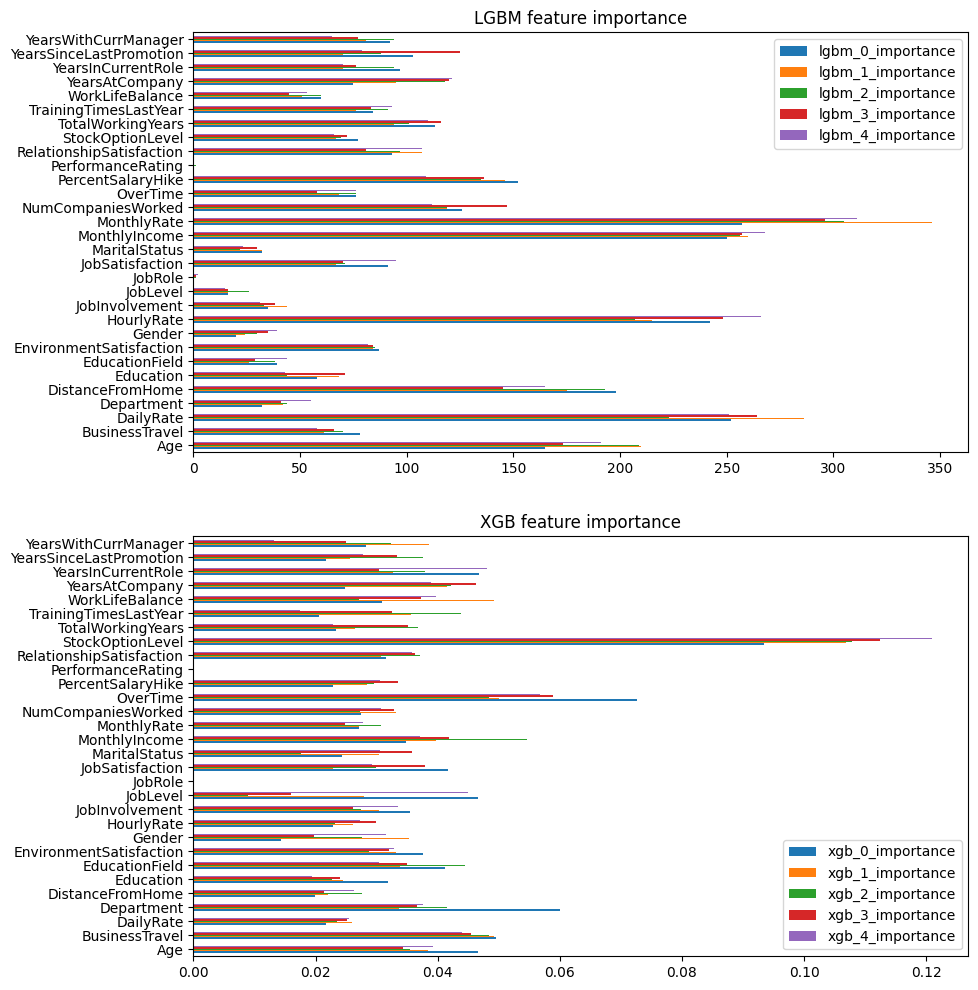

In [87]:
fig, axs = plt.subplots(2,1, figsize= (15,18))
axs[0] = fims[fims.columns[fims.columns.isin('lgbm_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='LGBM feature importance', ax = axs[0])
axs[1] = fims[fims.columns[fims.columns.isin('xgb_'+str(i)+'_importance' for i in range(0,5))]].plot(kind='barh', figsize=(10,12), title='XGB feature importance', ax= axs[1])
